In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Directory containing the dataset
DATASET_DIRECTORY = 'C:/Users/EDWIN/Downloads/CICIoT2023'


In [2]:
def load_and_preprocess_data(dataset_directory, sample_size=0.1, chunk_size=10000):
    df_sets = [k for k in os.listdir(dataset_directory) if k.endswith('.csv')]
    df_sets.sort()

    scaler = StandardScaler()
    label_encoder = LabelEncoder()
    X_list = []
    y_list = []

    for file in tqdm(df_sets):
        file_path = os.path.join(dataset_directory, file)
        total_rows = sum(1 for _ in open(file_path)) - 1  # Subtract 1 for header
        rows_to_sample = int(total_rows * sample_size)
        skip_rows = sorted(np.random.choice(range(1, total_rows + 1), total_rows - rows_to_sample, replace=False))

        for chunk in pd.read_csv(file_path, chunksize=chunk_size, skiprows=skip_rows):
            chunk.dropna(inplace=True)

            # Assuming the last column is the label
            X_chunk = chunk.iloc[:, :-1].values
            y_chunk = chunk.iloc[:, -1].values

            X_list.append(X_chunk)
            y_list.append(y_chunk)

    # Concatenate the processed chunks
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    # Normalize the features using the scaler
    X = scaler.fit_transform(X)

    # Encode the labels if not numeric
    y = label_encoder.fit_transform(y)

    return X, y, label_encoder


In [3]:

X, y, label_encoder = load_and_preprocess_data(DATASET_DIRECTORY, sample_size=0.3)


num_classes = len(np.unique(y))

100%|██████████| 169/169 [01:40<00:00,  1.68it/s]


In [4]:
num_classes

34

In [5]:
def build_deep_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)  # input_shape should be (timesteps, features)

    # Block 1
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Block 2
    x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Global Max Pooling and Fully Connected Layers
    x = GlobalMaxPooling1D()(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output Layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model


In [6]:
def train_model(X, y, num_classes):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape for CNN: Ensure X has shape (num_samples, timesteps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, timesteps, 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # (samples, timesteps, 1)

    # Build model
    model = build_deep_cnn_model((X_train.shape[1], 1), num_classes)  # Pass (timesteps, 1) as input_shape
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001)

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=1024, validation_split=0.2, 
                        callbacks=[early_stopping, reduce_lr], verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    return model, history


In [8]:
model, history = train_model(X, y, num_classes)

Epoch 1/10
8754/8754 ━━━━━━━━━━━━━━━━━━━━ 2135s 243ms/step - accuracy: 0.8759 - loss: 0.3456 - val_accuracy: 0.6773 - val_loss: 1.5761 - learning_rate: 0.0010
Epoch 2/10
8754/8754 ━━━━━━━━━━━━━━━━━━━━ 2144s 245ms/step - accuracy: 0.9665 - loss: 0.0883 - val_accuracy: 0.8966 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 3/10
8754/8754 ━━━━━━━━━━━━━━━━━━━━ 2169s 248ms/step - accuracy: 0.9805 - loss: 0.0614 - val_accuracy: 0.9804 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 4/10
8754/8754 ━━━━━━━━━━━━━━━━━━━━ 2194s 251ms/step - accuracy: 0.9807 - loss: 0.0572 - val_accuracy: 0.9683 - val_loss: 0.1560 - learning_rate: 0.0010
Epoch 5/10
8754/8754 ━━━━━━━━━━━━━━━━━━━━ 2224s 254ms/step - accuracy: 0.9832 - loss: 0.0523 - val_accuracy: 0.9835 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 6/10
8754/8754 ━━━━━━━━━━━━━━━━━━━━ 2258s 258ms/step - accuracy: 0.9845 - loss: 0.0483 - val_accuracy: 0.8520 - val_loss: 0.4615 - learning_rate: 0.0010
Epoch 7/10
8754/8754 ━━━━━━━━━━━━━━━━━━━━ 2402

C:\Users\thero\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\thero\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.77      0.98      0.86     66143
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       313
           4       0.99      0.99      0.99     17014
           5       0.93      0.90      0.91      1766
           6       1.00      1.00      1.00    431876
           7       0.98      0.99      0.98     27329
           8       1.00      1.00      1.00    245531
           9       1.00      1.00      1.00    243075
          10       1.00      0.96      0.98    243889
          11       0.74      0.85      0.79      1445
          12       0.96      1.00      0.98    216434
          13       1.00      1.00      1.00    269876
          14       1.00      1.00      1.00    323701
          15       0.99      0.99      0.99     17357
          16       0.55      0.31      0.39     10818
          17       0.87    

C:\Users\thero\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


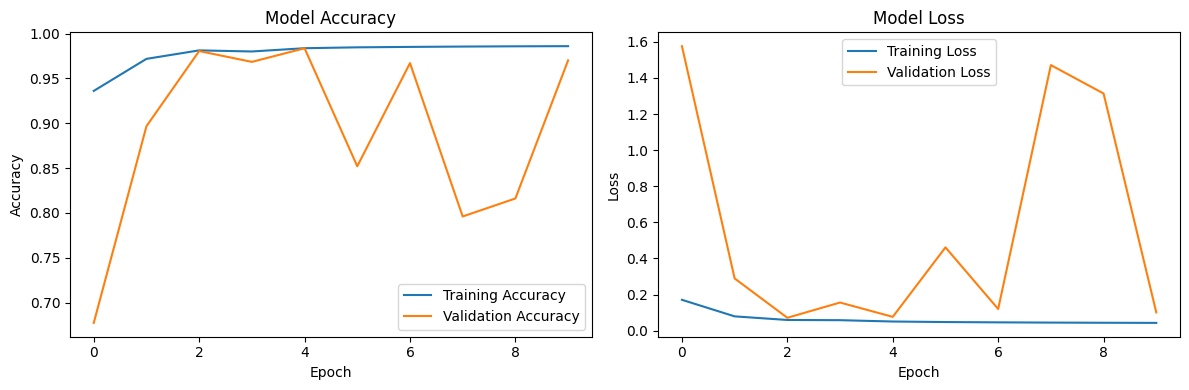

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# Save the model
model.save('iot_classification_model.h5')
print("Model saved as 'iot_classification_model.h5'")


Model saved as 'iot_classification_model.h5'
